In [ ]:
%pylab inline
plt.style.use("default")
import os, sys
import scipy
import helpers as h
from glob import glob
from scipy.io import loadmat
from scipy.sparse.linalg import eigsh
from mpl_toolkits import mplot3d
from scipy.stats import skewnorm 
from scipy.stats import skew, kurtosis
import matplotlib.gridspec as Gridspec
from scipy.cluster import hierarchy as H

plt.rcParams['figure.figsize'] = (15, 10) 

# Load functions for computations

In [390]:
def pad_vector(v, desired_length, pad_with = np.nan):
    v_new = np.zeros((desired_length,))
    v_new[:len(v)] = v
    v_new[len(v):] = pad_with
    return v_new


def abib_cdf(r, r_min = -np.inf, **kwargs):
    r_kept = r[r>r_min]
    print(f"Dropped {len(r) - len(r_kept)} values less than {r_min=}")
    x = sorted(r_kept)
    y = arange(1, len(r_kept)+1)/(len(r_kept))
    plot(x,y, **kwargs)
    xlabel("Samples"); ylabel("Cumulative Probability")
    return r_kept

def abib_metric(X):
    n = X.shape[0]
    X2 = X**2
    EX2 = mean(sum(X2, axis=0))
    r = EX2/n
    return r


def ro_orders(X, *args):
    "Returns a more structured dataset via Hierarchical clustering (scipy)"
    Zrow = H.linkage(clip(X,0,inf), method="average", metric="correlation")
    row_order = H.leaves_list(Zrow)
    Zcol = H.linkage(clip(X,0,inf).T, method="average", metric="correlation")
    col_order = H.leaves_list(Zcol)
    
    return row_order, col_order


# Load directory for data

In [331]:
data_root = "/Users/duuta/ppp/data/stringer/"
data_files = [fname.split("/")[-1] for fname in glob(f"{data_root}natimg2800_M*.mat")]

# Load data

In [332]:
data = loadmat(os.path.join(data_root, data_files[1])
               ,simplify_cells = True) 

In [333]:
resp = data['stim']['resp']

# computing covariances 

In [381]:
R = clip(resp, 0, inf)
C = corrcoef(R)
Ct= corrcoef(R.T)

# computing power law 

In [334]:
ss_resp = h.test_vars(resp)

In [335]:
alpha_resp, fit_resp = h.get_alpha_fit(ss_resp, np.arange(10, 5e2).astype('int'))

# Order neurons & images

In [391]:
row_order, col_order = ro_orders(resp)

In [396]:
def imboard(resp, row_order, col_order, ss_resp, fit_resp, alpha_resp):
    
    # data ppp 
    daata = sqrt(clip(resp[row_order][:,col_order][row_order, :], 0, inf))
    
    # covariances
    R = clip(resp, 0, inf)
    C = corrcoef(R)
    Ct= corrcoef(R.T)
    
    # xy values
    xvalues= mean(resp, axis=0)
    yvalues= arange(resp.shape[1])
    
    # logr 
    logr = log10(clip(resp, 1, inf))
    
    # plotting 
    fig0 = plt.figure(constrained_layout= True, figsize=(10, 10))
    gs= GridSpec(8, 8, figure=fig0)

    # data
    ax0_data = fig0.add_subplot(gs[0:2, :4])
    matshow(daata.T, cmap=cm.turbo, fignum=False, aspect='auto')
    title("Activity of ~10K Neurons")
    xlabel('Image')
    ylabel('Neuron')


    # mean of neurons 
    ax0_mnr = fig0.add_subplot(gs[0:2, 4:6] , sharey=ax0_data)
    plot(xvalues, yvalues, color='darkblue')
    title('Mean Activity of Neurons') 
    xlabel('Mean activity') 
    ylabel('Neurons') 


    # mean distribution across stimulus
    ax0_mir = fig0.add_subplot(gs[2:4, :4])
    plot(mean(resp, axis=1), color='darkblue')
    xlabel("Image")
    ylabel("Mean Activity")
    title("Mean Activity per Image/Stimulus ")

    # Histogram of the mean response across neurons
    ax0_mir = fig0.add_subplot(gs[2:4, 4:6])
    hist(mean(resp, axis=0), bins=100, color='darkblue')
    xlabel('Mean per neuron')
    ylabel('Count')
    title('Mean Distribution of Neurons')

    # Corr Neuron vs Neuron 
    ax0_mir = fig0.add_subplot(gs[4:6, 0:2])
    matshow(clip(C[row_order][:,row_order], 0, inf), cmap=cm.turbo, fignum=False, aspect='auto')
    xticks(rotation=30)
    xlabel('Neuron')
    ylabel('Neuron')
    title('Covariance')

    # Corr image of the mean response across neurons
    ax0_mir = fig0.add_subplot(gs[4:6, 2:4])
    matshow(clip(Ct[col_order][:,col_order], 0, inf), cmap=cm.turbo, fignum=False, aspect='auto')
    xticks(rotation=30)
    xlabel('Image')
    ylabel('Image')
    title('Covariance')

    # Power law of response 
    ax0_ivl = fig0.add_subplot(gs[4:6, 4:6])
    loglog(ss_resp, label='observed', color='darkblue')
    plot(fit_resp, label=f'fit ={round(alpha_resp, 2)}x', color='orange')
    xlabel('Dimensions')
    ylabel('Neuron')
    title('Response Power Law')
    legend()


    # Skewness (third order moment)  mean vs std
    ax0_ivl = fig0.add_subplot(gs[6:8, 0:2])
    plot(mean(logr, axis=0), std(logr, axis=0), 'o', color='darkblue')
    xlabel('Mean')
    ylabel('Std')
    title('Skewness ')

    # mean vs Skewness
    ax0_ivl = fig0.add_subplot(gs[6:8, 2:4])
    plot(mean(logr, axis=0), skew(logr), 'o', color='darkblue')
    xlabel('Mean')
    ylabel('Skewness')
    title('Mean vs Skewness ')

    # Skewness vs std 
    ax0_ivl = fig0.add_subplot(gs[6:8, 4:6])
    plot(std(logr, axis=0), skew(logr), 'o', color='darkblue')
    xlabel('Std')
    ylabel('Skewness')
    title('Std vs Skewness   ')

    tight_layout()
    
    return None 

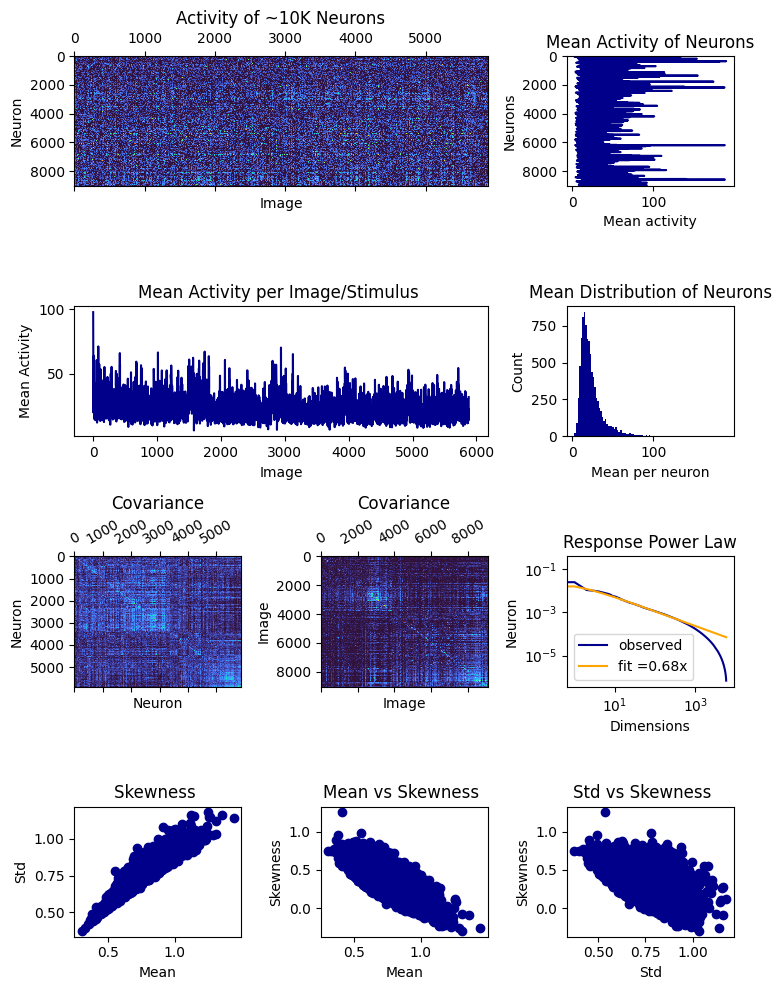

In [397]:
imboard(resp, row_order, col_order, ss_resp, fit_resp, alpha_resp)

In [269]:
s1 = randn(3, 2)

In [311]:
m0 = s0.T @ s0

In [270]:
m1 = s1.T @ s1 

In [278]:
m0v, m0e = eigsh(m0)
m1v, m1e = eigsh(m1)

In [288]:
diaM1 = m1e.T @ m1 @ m1e

In [291]:
diaM1i = sqrt(clip(inv(diaM1), 0, 1))

In [302]:
ff = matrix.round(abs(diaM1i @ m1e.T @ m1 @ m1e @ diaM1i), 2)

In [303]:
np.allclose(eye(2),  ff)

True

In [306]:
R = rand(3, 3)

In [307]:
M = R.T@ R 

In [314]:
P = inv(R).T @ m0 @ inv(R)

In [315]:
Pv, B = eigsh(P)

In [318]:
matrix.round(inv(B) @ P @ B, 2)

array([[ 0.12, -0.  , -0.  ],
       [-0.  ,  3.03,  0.  ],
       [-0.  ,  0.  , 21.87]])

In [319]:
C = inv(R) @ B 

In [323]:
matrix.round(C.T @ m0 @ C, 2)

array([[ 0.12, -0.  , -0.  ],
       [-0.  ,  3.03,  0.  ],
       [-0.  ,  0.  , 21.87]])